In [2]:
import seaborn as sn
import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
from collections import OrderedDict
from tqdm import tqdm_notebook as tqdm 


from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

In [1]:
IMAGE_TRAIN = "/kaggle/input/newdataset/Train"
IMAGE_TEST = "/kaggle/input/newdataset/Test"

In [3]:
batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 1024 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Resize((64,64)),
                                torchvision.transforms.RandomRotation(30),
                                torchvision.transforms.RandomRotation(120),
                                torchvision.transforms.RandomHorizontalFlip(),
                                torchvision.transforms.RandomVerticalFlip(),
                                torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
#image datasets
train_dataset = torchvision.datasets.ImageFolder(IMAGE_TRAIN, transform=image_transform)

test_dataset = torchvision.datasets.ImageFolder(IMAGE_TEST, transform=image_transform)

#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)

Label: tensor(2)


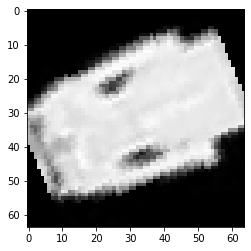

In [4]:
# import library

# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0][0]
# show the data
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[0]))

In [36]:
model = torchvision.models.vgg16(pretrained=True)

In [37]:
#first_conv_layer = [nn.Conv2d(1, 3, kernel_size=2, stride=1, padding=1), nn.ReLU(inplace=True)]
#model.features= nn.Sequential(*first_conv_layer)

newClassifier = nn.Sequential(
    OrderedDict([
        ('fc1', nn.Linear(25088, 4096)),
        ('relu', nn.ReLU()),
        ('drop', nn.Dropout(p = 0.5)),
        ('fc2', nn.Linear(4096, 11)),
        ('output', nn.LogSoftmax(dim = 1))
    ])
)

model.classifier = newClassifier

In [38]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [40]:
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss() 

In [41]:
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
##define test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [59]:
num_epoch = 25
for epoch in range(1, num_epoch + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.5161, Accuracy: 2761/3302 (84%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.5587, Accuracy: 2763/3302 (84%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4627, Accuracy: 2843/3302 (86%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4978, Accuracy: 2808/3302 (85%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4780, Accuracy: 2844/3302 (86%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4604, Accuracy: 2867/3302 (87%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4400, Accuracy: 2878/3302 (87%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4299, Accuracy: 2886/3302 (87%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4286, Accuracy: 2881/3302 (87%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4294, Accuracy: 2873/3302 (87%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4049, Accuracy: 2916/3302 (88%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4133, Accuracy: 2904/3302 (88%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.3879, Accuracy: 2911/3302 (88%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4389, Accuracy: 2880/3302 (87%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4603, Accuracy: 2873/3302 (87%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4805, Accuracy: 2929/3302 (89%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4289, Accuracy: 2910/3302 (88%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4032, Accuracy: 2913/3302 (88%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4129, Accuracy: 2925/3302 (89%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4002, Accuracy: 2916/3302 (88%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4950, Accuracy: 2914/3302 (88%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.5194, Accuracy: 2877/3302 (87%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.3906, Accuracy: 2957/3302 (90%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4149, Accuracy: 2918/3302 (88%)



  0%|          | 0/344 [00:00<?, ?it/s]


Test set: Average loss: 0.4223, Accuracy: 2955/3302 (89%)



In [60]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = []
y_true = []

for data, labels in test_loader:
        data = data.to(torch.device('cuda'))
        output = model(data) # Feed Network
        
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

classes = ("Ankle Boot","Bag","Coat","Dress","Pullover","Sandal","Shirt","Sneaker","Trouser","T-Shirt","Hat")


              precision    recall  f1-score   support

           0       0.91      0.94      0.92       300
           1       0.91      0.96      0.93       300
           2       0.86      0.70      0.77       300
           3       0.88      0.86      0.87       300
           4       0.73      0.84      0.78       302
           5       0.94      0.90      0.92       300
           6       0.85      0.86      0.86       300
           7       0.91      0.93      0.92       300
           8       0.99      0.97      0.98       300
           9       0.94      0.90      0.92       300
          10       0.90      0.93      0.91       300

    accuracy                           0.89      3302
   macro avg       0.89      0.89      0.89      3302
weighted avg       0.89      0.89      0.89      3302



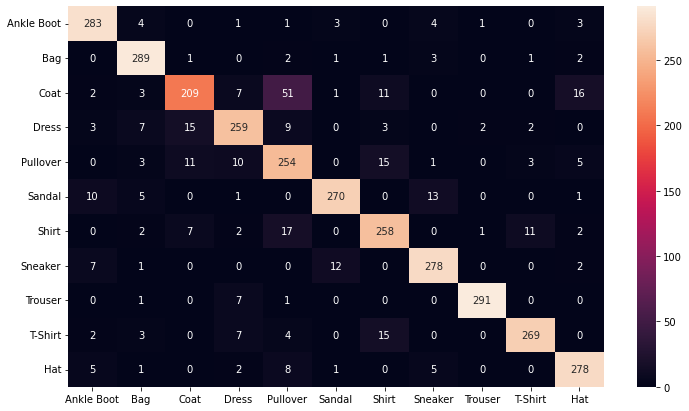

In [61]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, fmt="d",annot=True)
print(classification_report(y_true, y_pred))

In [62]:
torch.save(model.state_dict(), "Model_VGG16_Custom Dataset.pt")

In [63]:
from torchvision.transforms import transforms
image_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [64]:
def custom_image_pred(model, image_transforms, image_path, labels_data):
    image = Image.open(image_path)

 

    resize_image = image.resize((64,64))  
  
    image = image_transforms(image).float()
    image = image.unsqueeze(0).to(device)

    output = model(image)
    probs = F.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)

    return labels_data[classes.item()], round(conf.item(), 3), resize_image

In [65]:
from PIL import Image, ImageOps

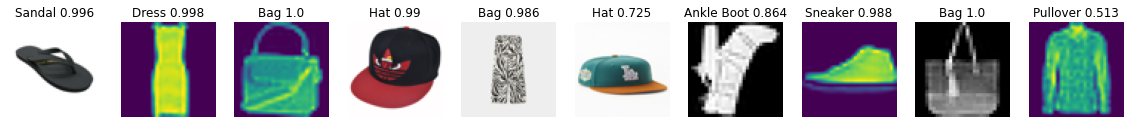

In [66]:

from os import listdir 
labels_data ={
    0: "Ankle Boot",
    1: "Bag",
    2: "Coat",
    3: "Dress",
    4: "Pullover",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Trouser",
    9: "T-Shirt",
    10: "Hat",
}

folder_dir = "/kaggle/input/imagetest/"
image_list = []

for images in listdir(folder_dir):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
        image_list.append(str(folder_dir+images))

fig = plt.figure(figsize=(20, 8))
cols, rows = len(image_list), 1

for i in range(1, cols * rows + 1):
    labels_pred, conf, image = custom_image_pred(model, image_transforms, image_list[i-1], labels_data)
    
    fig.add_subplot(rows, cols, i)
    plt.title(f'{labels_pred} {conf}')
    plt.axis('off')
    plt.imshow(image)
plt.show()